In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import argparse
import importlib  
from keras.optimizers import Adam
import os
import time
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib
from utils.keras_functions import sparse_crossentropy_ignoring_last_label, Jaccard
import Keras_segmentation_deeplab_v3_1.utils

keras_deeplab = importlib.import_module("keras-deeplab-v3-plus.model")

image_size = (512,512)

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard]}


def build_model(model_name, os, alpha, norm):
    try:
        deeplab_model = keras_deeplab.Deeplabv3(backbone=model_name, input_shape=(512, 512, 3), classes=19, weights='cityscapes', OS=os, alpha=alpha, infer=True, normalization=norm)
    except:
        raise Exception("No model with given backbone: ", model_name)

    deeplab_model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
    return deeplab_model

def load_model(path):
    deeplab_model = tf.keras.models.load_model(path, custom_objects={
        'sparse_crossentropy_ignoring_last_label': sparse_crossentropy_ignoring_last_label,
        'Jaccard': Jaccard
        })

    return deeplab_model


Version 2.x.x


In [2]:
model = build_model('xception', 8, 1., 1)

Cityscapes!


In [3]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         lambda[0][0]                     
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [11]:
model = keras_deeplab.Deeplabv3(backbone='xception', input_shape=(512, 512, 3), classes=19, weights='cityscapes', infer=True)

model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
          loss = losses, metrics = metrics)

Cityscapes!


In [7]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 512, 512, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 256, 256, 32) 864         lambda_6[0][0]                   
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 256, 256, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from PIL import Image

def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_cityscapes_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 
               'traffic light', 'traffic sign', 'vegetation', 'terraain', 'sky', 'person', 
               'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle','unknown'])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

(512, 512, 3)
(1, 512, 512, 3)


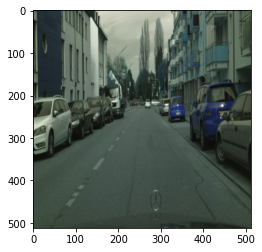

In [3]:
import cv2
import numpy as np

city_image = cv2.imread("../cityscapes_test.png", 3)
city_image = cv2.resize(city_image, (512,512))
plt.imshow(city_image)
print(city_image.shape)
print(np.expand_dims(city_image, 0).shape)

In [5]:
a = model.predict(np.expand_dims(city_image, 0))

In [8]:
labels = np.argmax(a.squeeze(), -1)
print(labels.shape)

(512, 512)


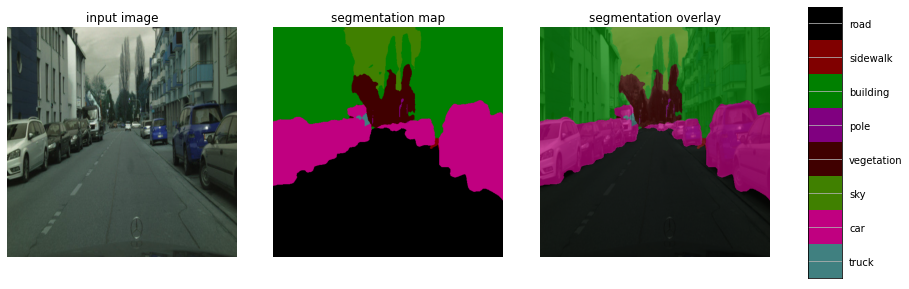

In [9]:
vis_segmentation(city_image, labels)